# ARIMA

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))

Warning message:
"package 'ggplot2' was built under R version 4.3.2"


## Stationary

### Google Price Level

In [ ]:
goog <- gafa_stock %>% filter(Symbol == 'GOOG') %>% filter(Date >= as.Date('2018-01-01'))

goog %>% autoplot(Close) + labs(x='', y='', title='Google Stock Price ($)')

In [ ]:
goog %>% gg_tsdisplay(Close)

In [ ]:
goog %>% features(Close, ljung_box, lag=10)

In [ ]:
goog %>% features(Close, ljung_box, lag=10)

### Change or Difference in Google's Price

In [ ]:
goog %>% autoplot(difference(Close))+ labs(x='', y='', title='Change in Google Stock Price ($)')

In [ ]:
goog %>% gg_tsdisplay(difference(Close))

In [ ]:
goog %>% features(difference(Close), ljung_box, lag=10)

### Differenced-Log in Google's Stock Price

In [ ]:
goog %>% gg_tsdisplay(difference(log(Close)))

In [ ]:
goog %>% features(difference(log(Close),differences=1), ljung_box, lags=10)

## Seasonal Differencing

In [ ]:
drugs <- PBS |>
  filter(ATC2 == "H02") |>
  summarise(Cost = sum(Cost)/1e6) |>
  transmute(
    `Sales ($million)` = Cost,
    `Log sales` = log(Cost),
    `Annual change in log sales` = difference(log(Cost), 12),
    `Doubly differenced log sales` =
                     difference(difference(log(Cost), 12), 1)
  ) |>
  pivot_longer(-Month, names_to="Type", values_to="Sales") |>
  mutate(
    Type = factor(Type, levels = c(
      "Sales ($million)",
      "Log sales",
      "Annual change in log sales",
      "Doubly differenced log sales"))
  )

  drugs %>%
  ggplot(aes(x = Month, y = Sales)) +
  geom_line() +
  facet_grid(vars(Type), scales = "free_y") +
  labs(title = "Corticosteroid drug sales", y = NULL)

In [ ]:
drugs %>% filter(Type == "Annual change in log sales") %>% gg_tsdisplay()

In [ ]:
drugs %>% filter(Type == "Annual change in log sales") %>%
features(Sales, ljung_box, lags=12)

In [ ]:
drugs %>% filter(Type == "Doubly differenced log sales") %>% gg_tsdisplay()

In [ ]:
drugs %>% filter(Type == "Doubly differenced log sales") %>%
features(Sales, ljung_box, lags=12)

## Unit Root Tests

In [ ]:
goog %>% features(Close, unitroot_kpss)

In [ ]:
goog %>% features(difference(Close), unitroot_kpss)

In [ ]:
goog %>% features(Close, unitroot_ndiffs)

## ARMA Example

In [ ]:
usa <- global_economy %>% filter(Code == "USA")
usa %>% gg_tsdisplay(CPI, plot_type = 'partial') + labs(title='US CPI')

In [ ]:
usa %>% model(ARIMA(CPI)) %>% report()

## Modeling Processing Using CPI

In [2]:
cpi <- read.csv('data/CPIAUCSL.csv') %>%
mutate(DATE = yearmonth(as.Date(DATE))) %>%
as_tsibble(index=DATE) %>%
rename(`Price Index` = CPIAUCSL)

cpi %>% head()

DATE,Price Index
<mth>,<dbl>
1947 Jan,21.48
1947 Feb,21.62
1947 Mar,22.00
1947 Apr,22.00
1947 May,21.95
1947 Jun,22.08


### Plot the data and observe

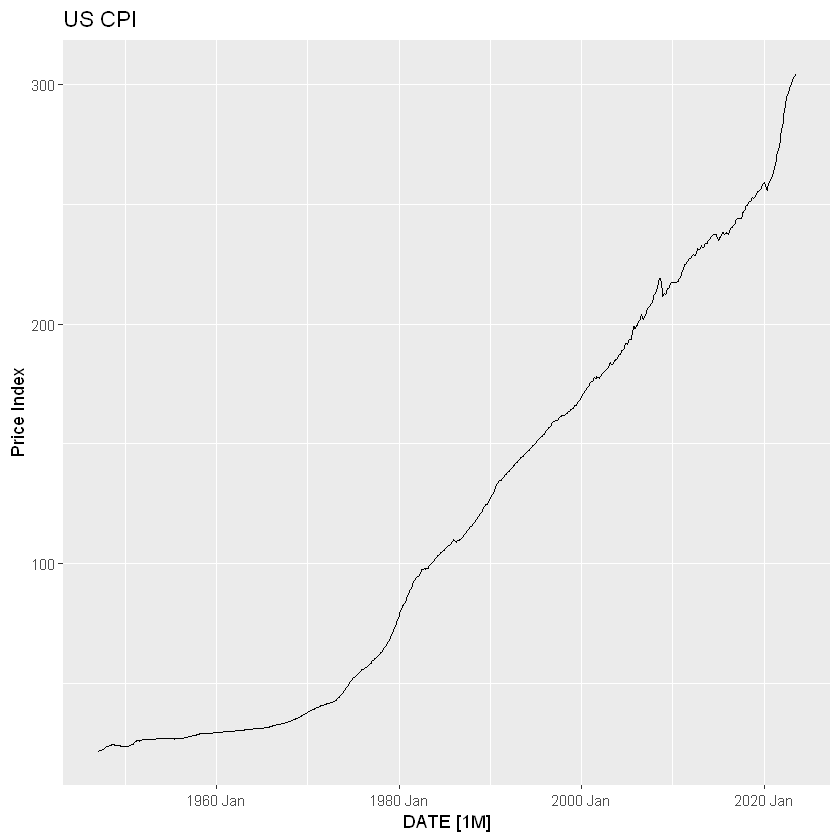

In [3]:
cpi %>% autoplot(`Price Index`) + labs(title='US CPI')

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


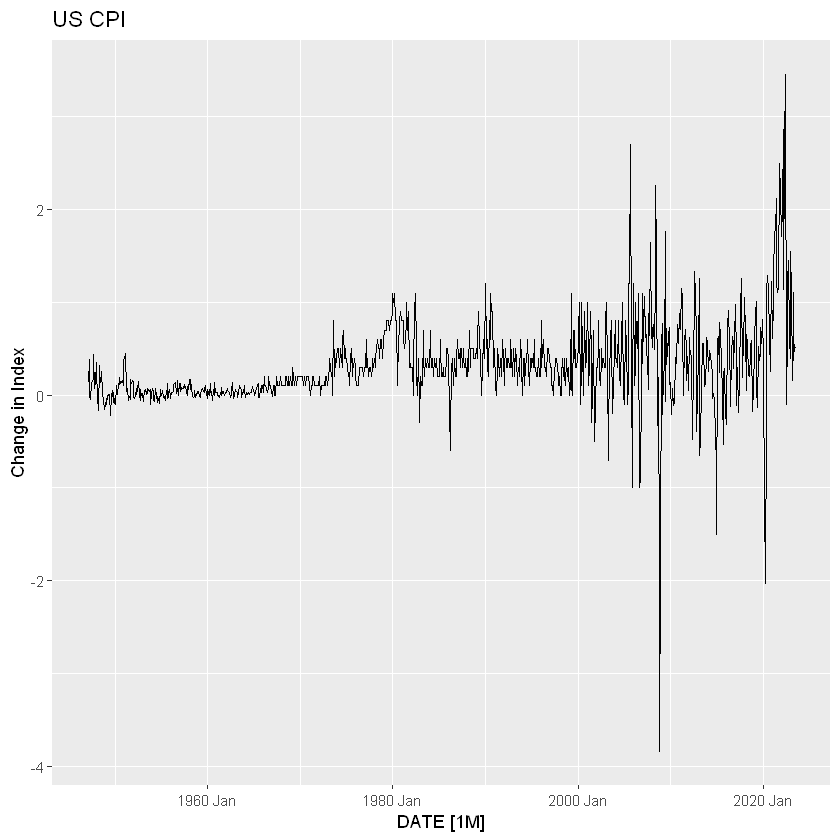

In [4]:
cpi %>% autoplot(difference(`Price Index`)) + labs(title='US CPI', y='Change in Index')

### Need to remove the exponential trend, take the log of the time series

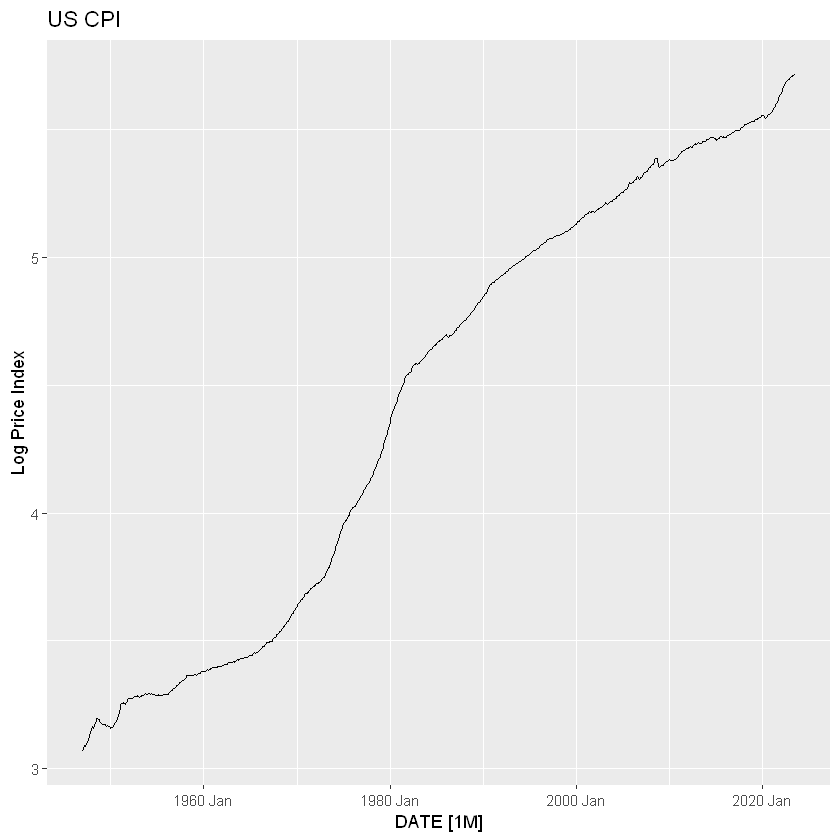

In [5]:
cpi %>% autoplot(log(`Price Index`)) + labs(title='US CPI', y='Log Price Index')

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


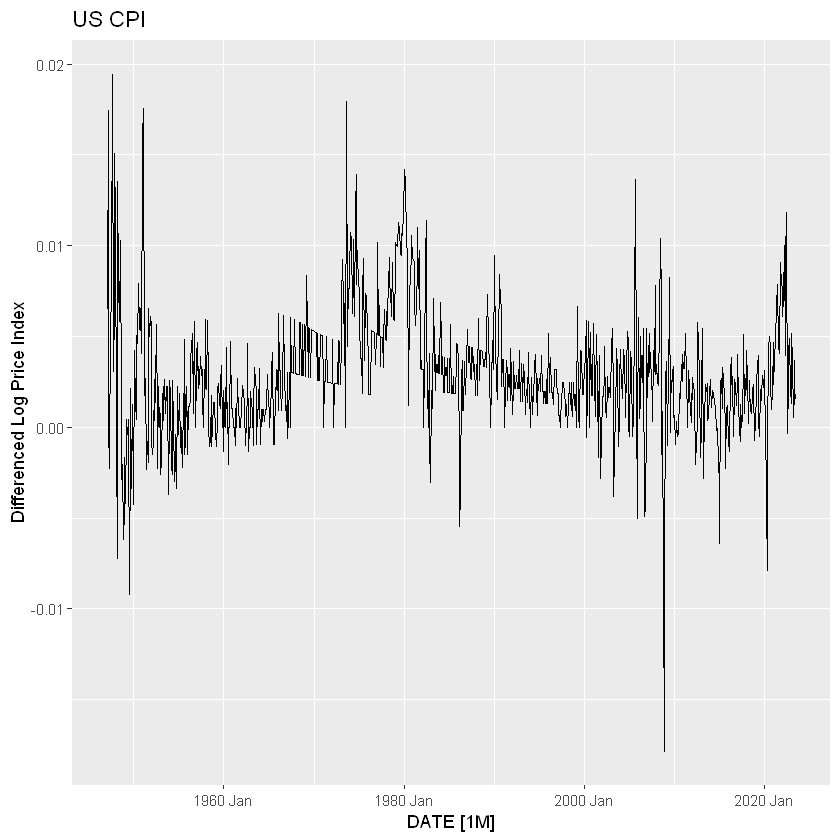

In [6]:
cpi %>% autoplot(difference(log(`Price Index`))) + labs(title='US CPI', y='Differenced Log Price Index')

### Determine number of differences

In [7]:
cpi %>% features(log(`Price Index`), unitroot_ndiffs)

ndiffs
<int>
2


Warning message:
"Removed 2 rows containing missing values (`geom_line()`)."


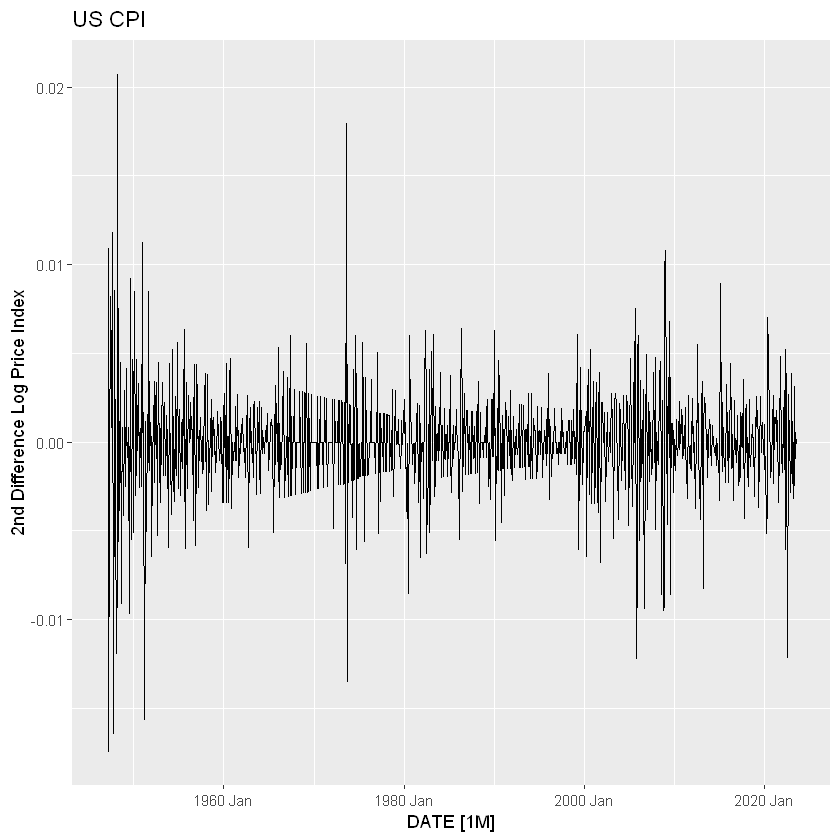

In [8]:
cpi %>% autoplot(difference(log(`Price Index`), differences=2)) + labs(title='US CPI', y='2nd Difference Log Price Index')

### ACF and PACFs on Differenced Data to Determine p, q seed

Warning message:
"Removed 2 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_point()`)."


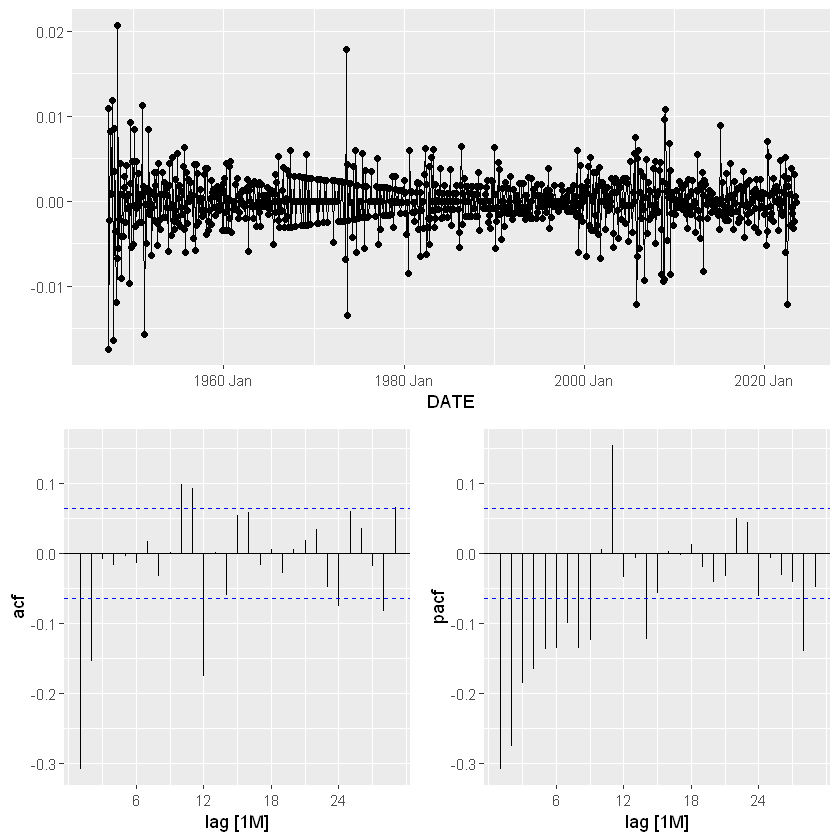

In [9]:
cpi %>% gg_tsdisplay(difference(log(`Price Index`), differences=2), plot_type = 'partial') + labs(y='')

### Model around a ARIMA(0,2,2) seed

In [10]:
cpi %>%
model(ARIMA(log(`Price Index`) ~ pdq(0:1,1:2,1:3)+PDQ(0,0,0))) %>% report()

Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"


Series: Price Index 
Model: ARIMA(1,2,3) 
Transformation: log(`Price Index`) 

Coefficients:
          ar1     ma1      ma2      ma3
      -0.7265  0.1665  -0.6602  -0.1801
s.e.      NaN     NaN      NaN   0.0179

sigma^2 estimated as 7.373e-06:  log likelihood=4120.06
AIC=-8230.12   AICc=-8230.05   BIC=-8206.01


Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"


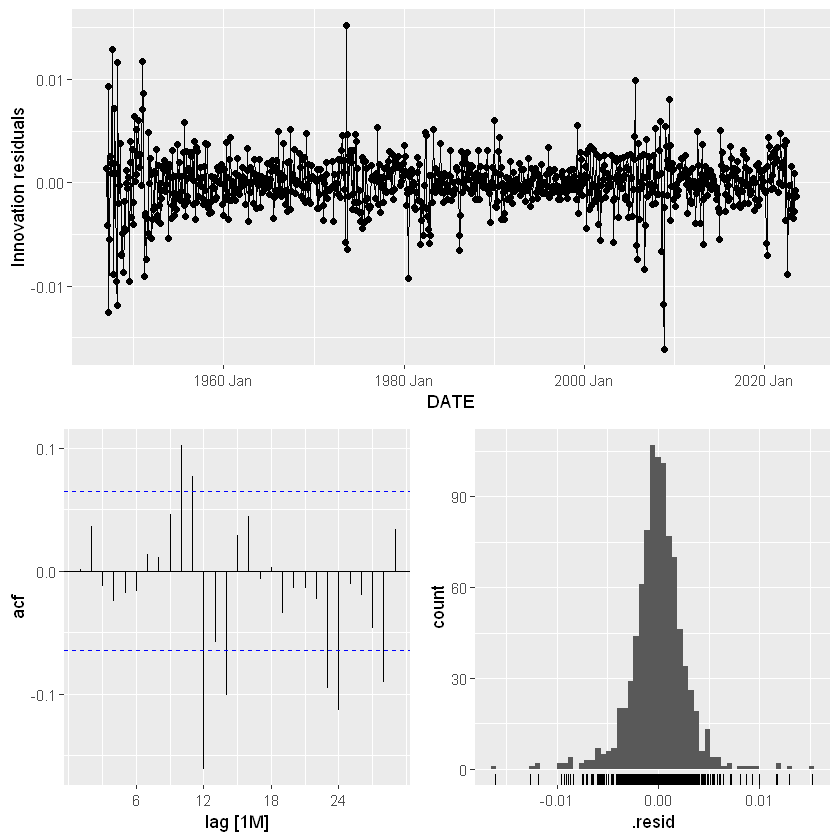

In [11]:
cpi_arima <- cpi %>%
model(ARIMA(log(`Price Index`) ~ 0 + pdq(0:1,1:2,1:3)+PDQ(0,0,0)))

cpi_arima %>% gg_tsresiduals()

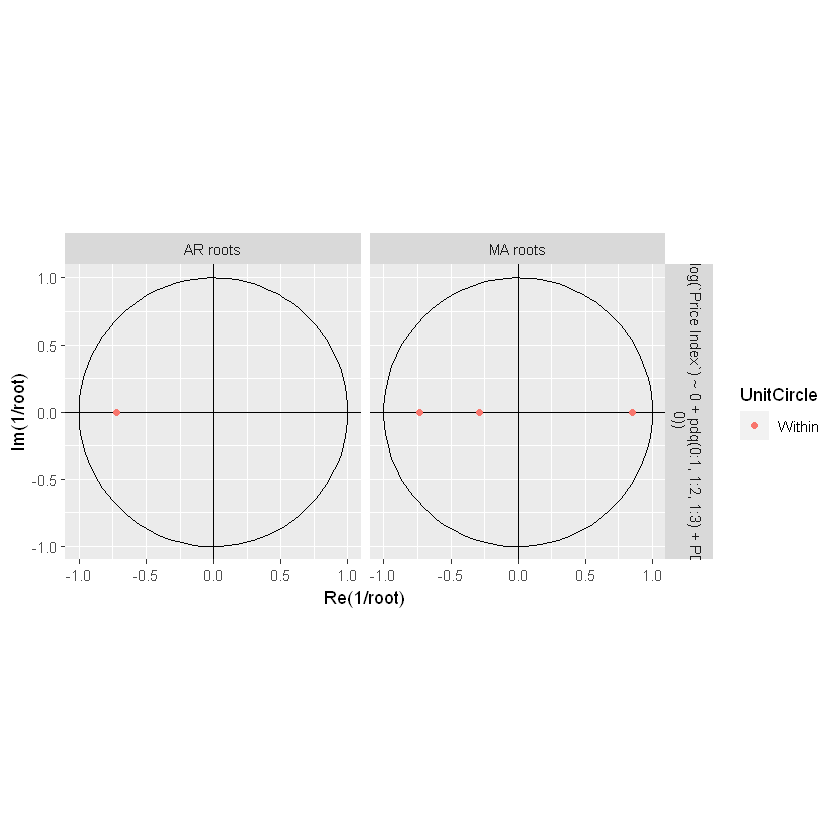

In [12]:
gg_arma(cpi_arima)

### Compare to Seasonal Model

In [13]:
cpi_sarima <- cpi %>%
model(
    `Non Seasonal ARIMA` = ARIMA(log(`Price Index`) ~ 0+ pdq(1,2,3) + PDQ(0,0,0)),
    `Seasonal ARIMA` = ARIMA(log(`Price Index`) ~ 0+ pdq(1,2,3)+PDQ(1,0,0))
)

cpi_sarima %>% report() %>% select(.model, AICc)

Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in report.mdl_df(.):
"Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model."


.model,AICc
<chr>,<dbl>
Non Seasonal ARIMA,-8230.051
Seasonal ARIMA,-8257.856


In [14]:
cpi_sarima %>% select(`Non Seasonal ARIMA`) %>% report()

Series: Price Index 
Model: ARIMA(1,2,3) 
Transformation: log(`Price Index`) 

Coefficients:
          ar1     ma1      ma2      ma3
      -0.7265  0.1665  -0.6602  -0.1801
s.e.      NaN     NaN      NaN   0.0179

sigma^2 estimated as 7.373e-06:  log likelihood=4120.06
AIC=-8230.12   AICc=-8230.05   BIC=-8206.01


In [15]:
cpi_sarima %>% select(`Seasonal ARIMA`) %>% report()

Series: Price Index 
Model: ARIMA(1,2,3)(1,0,0)[12] 
Transformation: log(`Price Index`) 

Coefficients:
          ar1     ma1      ma2     ma3     sar1
      -0.6655  0.1118  -0.6136  -0.162  -0.1893
s.e.      NaN     NaN      NaN     NaN   0.0343

sigma^2 estimated as 7.142e-06:  log likelihood=4134.97
AIC=-8257.95   AICc=-8257.86   BIC=-8229.02


In [ ]:
cpi_sarima %>% select(`Seasonal ARIMA`) %>% gg_tsresiduals()

### Compare to Automate Modeling

In [ ]:
cpi_auto <- cpi %>%
model(ARIMA(log(`Price Index`))) 

cpi_auto %>% report()

In [ ]:
cpi_auto %>% gg_tsresiduals()

In [ ]:
augment(cpi_auto) |> features(.innov, ljung_box, lag = 12, dof = 3)

### Forecast Using the Best Model (the automatic selection)

In [ ]:
cpi_auto %>% forecast(h=48) %>% autoplot(cpi) + labs(title='US CPI Forecasts')

### ARIMA vs ETS

In [ ]:
cpi_training <- cpi %>% filter_index(. ~ 'Dec 2020')
cpi_test <- cpi %>% filter_index('Jan 2021' ~ .)

cpi_models <- cpi_training %>%
model(
    `ARIMA` = ARIMA(log(`Price Index`)),
    `ETS` = ETS(log(`Price Index`))
)

cpi_models %>% report()

In [ ]:
cpi_models %>% select(ARIMA) %>% gg_tsresiduals() + labs(title='ARIMA')

In [ ]:
cpi_models %>% select(ETS) %>% gg_tsresiduals() + labs(title='ETS')

In [ ]:
bind_rows((cpi_models %>% accuracy()),cpi_models %>% forecast(cpi_test) %>% accuracy(cpi_test)) %>% select(-MASE, -RMSSE, -ME, -MAE, -MPE)

In [ ]:
cpi_models %>% select(ETS) %>% report() %>% glance()

In [ ]:
cpi_models %>% select(ETS) %>% forecast(cpi_test) %>% autoplot(cpi_training) +
autolayer(cpi_test, `Price Index`, col='red')

### Retrain and Out-of-Sample

In [ ]:
cpi %>% model(ETS(log(`Price Index`))) %>% report()

In [ ]:
cpi %>% model(ETS(log(`Price Index`))) %>% forecast(horizon=48) %>% autoplot(cpi) + labs(title='ETS 48-Month Forecasts')

In [ ]:
cpi %>% model(ETS(log(`Price Index`)~trend('A')+error('A')+season('N'))) %>% forecast(horizon=48) %>% autoplot(cpi) + labs(title='ETS 48-Month Forecasts')

In [ ]:
cpi %>% model(ARIMA(log(`Price Index`))) %>% forecast(horizon=48) %>% autoplot(cpi) + labs(title='ARIMA 48-Month Forecasts')

### Retail Sales

In [ ]:
retail <- read.csv('data/RSXFSN.csv')
retail |> head(1)

#### Tidying
Tidy the data and calculate the year-over-year change.

In [ ]:
retail <- retail |>
rename(Sales = RSXFSN) |>
mutate(SalesYOY = Sales/lag(Sales,n = 12)-1) |>
mutate(DATE = yearmonth(as.Date(DATE))) |>
filter(!is.na(SalesYOY)) %>%
as_tsibble(index = DATE)

retail |> head(1)

### Basic Plot of the Series

In [ ]:
retail |> autoplot(Sales) +
labs(title = 'Retail Sales', x='', y='')

In [ ]:
retail |> features(Sales, unitroot_kpss)

In [ ]:
retail |> autoplot(SalesYOY) +
labs(title = 'Retail Sales - Year-over-Year', x='', y='Percent Change') +
scale_y_continuous(labels=scales::percent) +
geom_hline(yintercept = 0)

In [ ]:
retail |> features(SalesYOY, unitroot_kpss)

### Determine the ARIMA Terms Based on ACF and PACF

In [ ]:
g1 <- retail |> ACF(SalesYOY) |> autoplot()
g2 <- retail |> PACF(SalesYOY) |> autoplot()

grid.arrange(g1, g2, ncol=2)

### Split into Training and Test

In [ ]:
retail_tr <- retail |> filter_index(. ~ 'Dec 2022')
retail_ts <- retail |> filter_index('Jan 2023' ~ .)

### Fit Models

In [ ]:
retail_mdl <- retail_tr |>
model(
    'ARIMA' = ARIMA(SalesYOY),
    'ETS' = ETS(SalesYOY),
    'Naive' = NAIVE(SalesYOY)
)

retail_mdl |> select(ARIMA) |> report() 

In [ ]:
retail_mdl  |> accuracy() |> select(.model, RMSE, MAPE)

### Inspect Residuals

In [ ]:
retail_mdl |> select('ARIMA') |> gg_tsresiduals()

In [ ]:
retail_mdl |> select('ETS') |> gg_tsresiduals()

In [ ]:
retail_mdl |> select('Naive') |> gg_tsresiduals()

### Evaluate Forecasts

In [ ]:
retail_mdl_fcst <- retail_mdl |>
forecast(retail_ts) 

retail_mdl_fcst |> accuracy(retail_ts) |> select(.model, RMSE, MAPE)

In [ ]:
retail_mdl_fcst |> autoplot(level=NULL) +
autolayer(retail, SalesYOY) +
labs(title='Retail Sales Year-over-Year Forecast', x='', y='Percent (%)') +
geom_vline(xintercept = as.Date('2023-01-01'), linetype='dashed') +
geom_hline(yintercept = 0) +
scale_y_continuous(labels=scales::percent)

### Retrain and Forecast Out-of-Sample

In [ ]:
retail_mdl_fnl <- retail |>
model(
    'ARIMA' = ARIMA(SalesYOY)
)

retail_mdl_fnl %>% report()

In [ ]:
retail_mdl_fnl |> forecast(h=12) |>
autoplot() + 
autolayer(retail, SalesYOY) +
labs(title='Retail Sales Year-over-Year Forecast', x='', y='Percent (%)')